In [1]:
# set up some environmental dependencies
import time, sys, os
import h5py
import numpy as np
from astropy.table import Table
import scipy
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table
import astropy.cosmology.units as cu
import astropy.units as u
from matplotlib.pyplot import *
import seaborn as sns
import numpy as np, matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from astropy.io import ascii
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
import matplotlib
from astropy.table import Table
import warnings
warnings.filterwarnings("ignore")

# standard imports for my work
from bpt_utils import *
from read_transients_data import *
from correct_redshift_evolution import *
from generate_bkg_galaxies import *
from helper_functions import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'
sns.set_context('talk') 
sns.set(font_scale=1.4)
sns.set_palette('colorblind')
sns.set_style('ticks')
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Verdana', 'Lucida Grande', 'DejaVu Sans']

cmap = matplotlib.cm.get_cmap('magma_r')
colors = ["white", "white", "white"]+[cmap(i/100) for i in range(100)]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                                           colors)


In [2]:
# Reading in SDSS emission line fluxes
bptdat = pd.read_csv("../results_v2/data/SDSS_BPT.csv")
snr_thresh = 10
mask1 = np.logical_and(bptdat["oiii_5007_flux"]/bptdat["oiii_5007_flux_err"]>snr_thresh,
                      bptdat["h_beta_flux"]/bptdat["h_beta_flux_err"]>snr_thresh)
mask2 = np.logical_and(bptdat["nii_6584_flux"]/bptdat["nii_6584_flux_err"]>snr_thresh,
                      bptdat["h_alpha_flux"]/bptdat["h_alpha_flux_err"]>snr_thresh)
mask3 = np.logical_and(bptdat["sii_6717_flux"]/bptdat["sii_6717_flux_err"]>snr_thresh,
                      bptdat["sii_6731_flux"]/bptdat["sii_6731_flux_err"]>snr_thresh)
mask4 = bptdat["oi_6300_flux"]/bptdat["oi_6300_flux_err"]>snr_thresh
mask = np.logical_and(mask1, mask2)
mask = np.logical_and(mask, mask3)
mask = np.logical_and(mask, mask4)

bptdat = bptdat[mask].reset_index()

bptdat.head()

,index,specObjID,oiii_4959_flux,oiii_4959_flux_err,oiii_5007_flux,oiii_5007_flux_err,h_beta_flux,h_beta_flux_err,nii_6548_flux,nii_6548_flux_err,nii_6584_flux,nii_6584_flux_err,h_alpha_flux,h_alpha_flux_err,sii_6717_flux,sii_6717_flux_err,sii_6731_flux,sii_6731_flux_err,oi_6300_flux,oi_6300_flux_err
0,91,299503421340280832,32.83901,3.867179,95.84792,4.246964,257.9409,4.885870,186.80880,2.018863,563.4586,6.089350,1151.2110,9.593594,194.4022,4.352325,153.68080,4.440993,32.05777,3.175750
1,95,299504245974001664,47.49470,2.931503,203.21100,8.831159,194.0930,3.757110,127.59600,1.567992,384.8589,4.729420,919.3564,8.633987,140.5348,3.134246,110.58970,2.835191,30.05624,2.113387
2,104,299505894771681280,39.45840,2.905433,131.32030,6.475480,192.5399,3.768797,116.24740,1.677521,350.6291,5.059785,863.9615,8.067708,136.0053,3.368287,105.14760,3.291207,31.44542,2.312924
3,143,299511667207727104,21.30112,2.355875,47.01003,2.834701,115.5547,2.989640,61.75349,1.005389,186.2628,3.032482,615.6885,5.857655,117.1578,2.750722,82.45193,2.511887,19.10643,1.868355
4,156,299513316944930816,13.54014,2.415372,51.88348,2.842988,117.5592,3.160311,62.19669,0.991653,187.5996,2.991050,625.9243,5.773787,125.9418,2.783081,82.95983,2.508759,22.94478,1.862804


In [3]:
log_NII_Halpha1 = np.linspace(-1.2, 0, 100)
log_NII_Halpha2 = np.linspace(-2, 0.3, 100)
log_SII_Halpha1 = np.linspace(-1.5, 0.2, 100)
log_SII_Halpha2 = np.linspace(-0.31, 1, 100)
log_OI_Halpha1 = np.linspace(-2.5, -0.75, 100)
log_OI_Halpha2 = np.linspace(-1.13, 0, 100)

log_OIII_Hbeta_Ke01 = (0.61/(log_NII_Halpha1-0.05)) + 1.3
log_OIII_Hbeta_Ka03_1 = (0.61/(log_NII_Halpha2-0.47)) + 1.19
log_OIII_Hbeta_Ka03_2 = (0.72/(log_SII_Halpha1-0.32)) + 1.3
log_OIII_Hbeta_Ka03_3 = (0.73/(log_OI_Halpha1+0.59)) + 1.33
log_OIII_Hbeta_Ke03_1 = (1.89*log_SII_Halpha2)+0.76
log_OIII_Hbeta_Ke03_2 = (1.18*log_OI_Halpha2)+1.30

Text(0.02, 1.04, 'c')

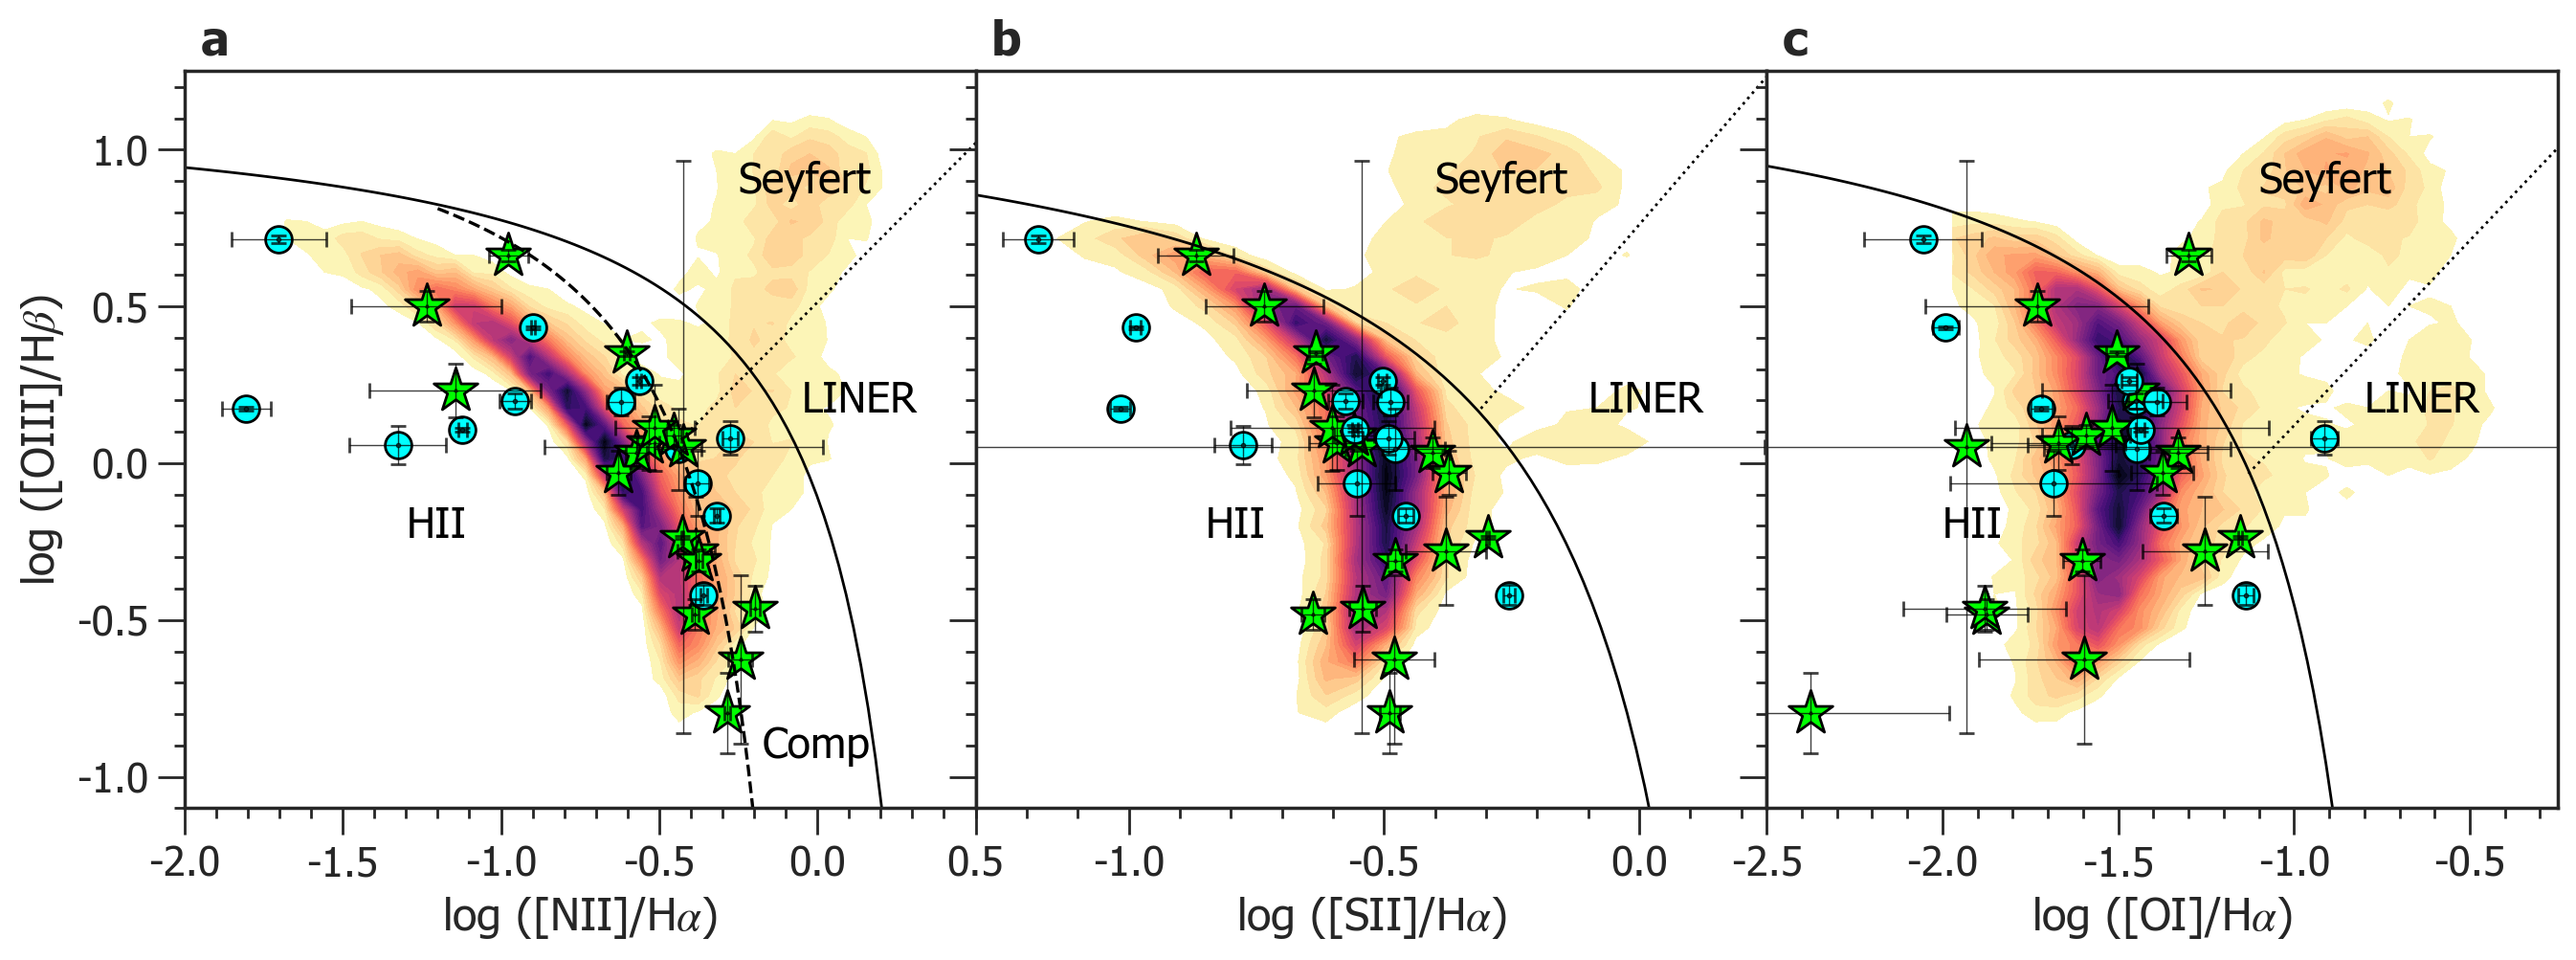

In [4]:
import matplotlib as mpl

cmap = matplotlib.cm.get_cmap('magma_r')
colors = ["white", "white", "white"]+[cmap(i/100) for i in range(100)]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                                           colors)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), sharey=True)
fig.subplots_adjust(wspace=0)

xbins, ybins = 50, 50
counts, xedges, yedges = np.histogram2d(np.log10(bptdat["nii_6584_flux"]/bptdat["h_alpha_flux"]),
                                        np.log10(bptdat["oiii_5007_flux"]/bptdat["h_beta_flux"]),
                                        bins=(xbins, ybins),
                                        range=[[-2, 0.95], [-1.2, 1.5]])
xs, ys = [], []
for i in range(len(xedges)-1):
    xs.append((xedges[i]+xedges[i+1])/2), ys.append((yedges[i]+yedges[i+1])/2)
mplt = ax[0].contourf(xs, ys, counts.transpose(), 30, cmap=cmap)

ax[0].plot(log_NII_Halpha1,
           log_OIII_Hbeta_Ke01,
           color="black",
           linewidth=1.2,
           linestyle="--")
ax[0].plot(log_NII_Halpha2,
           log_OIII_Hbeta_Ka03_1,
           color="black",
           linewidth=1,
           linestyle="solid")
ax[0].plot([-0.4467637356387215, 0.7464452280741671],
           [0.05932203389830515, 1.2711864406779658],
           color="black",
           linewidth=1,
           linestyle="dotted")

ax[0].set_xlim(-2, 0.5)
ax[0].set_ylim(-1.1, 1.25)
ax[0].set_xlabel(r'log ([NII]/H$\alpha$)')
ax[0].set_ylabel(r'log ([OIII]/H$\beta$)')
ax[0].text(-1.3, -0.2, 'HII', color="black", ha='left', va='center', fontsize=16)
ax[0].text(-0.175, -0.9, 'Comp', color="black", ha='left', va='center', fontsize=16)
ax[0].text(-0.25, 0.9, 'Seyfert', color="black", ha='left', va='center', fontsize=16)
ax[0].text(-0.05, 0.2, 'LINER', color="black", ha='left', va='center', fontsize=16)

xbins, ybins = 50, 50
counts, xedges, yedges = np.histogram2d(np.log10((bptdat["sii_6717_flux"]+bptdat["sii_6731_flux"])/bptdat["h_alpha_flux"]),
                                        np.log10(bptdat["oiii_5007_flux"]/bptdat["h_beta_flux"]),
                                        bins=(xbins, ybins),
                                        range=[[-2, 0.95], [-1.2, 1.5]])
xs, ys = [], []
for i in range(len(xedges)-1):
    xs.append((xedges[i]+xedges[i+1])/2), ys.append((yedges[i]+yedges[i+1])/2)
mplt = ax[1].contourf(xs, ys, counts.transpose(), 30, cmap=cmap)


ax[1].plot(log_SII_Halpha1,
           log_OIII_Hbeta_Ka03_2,
           color="black",
           linewidth=1,
           linestyle="solid")
ax[1].plot(log_SII_Halpha2,
           log_OIII_Hbeta_Ke03_1,
           color="black",
           linewidth=1,
           linestyle="dotted")
ax[1].set_xlim(-1.3, 0.25)
ax[1].set_xlabel(r'log ([SII]/H$\alpha$)')
ax[1].text(-0.85, -0.2, 'HII', color="black", ha='left', va='center', fontsize=16)
ax[1].text(-0.4, 0.9, 'Seyfert', color="black", ha='left', va='center', fontsize=16)
ax[1].text(-0.1, 0.2, 'LINER', color="black", ha='left', va='center', fontsize=16)

xbins, ybins = 50, 50
counts, xedges, yedges = np.histogram2d(np.log10(bptdat["oi_6300_flux"]/bptdat["h_alpha_flux"]),
                                        np.log10(bptdat["oiii_5007_flux"]/bptdat["h_beta_flux"]),
                                        bins=(xbins, ybins),
                                        range=[[-2, 0.95], [-1.2, 1.5]])
xs, ys = [], []
for i in range(len(xedges)-1):
    xs.append((xedges[i]+xedges[i+1])/2), ys.append((yedges[i]+yedges[i+1])/2)
mplt = ax[2].contourf(xs, ys, counts.transpose(), 30, cmap=cmap)


ax[2].plot(log_OI_Halpha1,
           log_OIII_Hbeta_Ka03_3,
           color="black",
           linewidth=1,
           linestyle="solid")
ax[2].plot(log_OI_Halpha2,
           log_OIII_Hbeta_Ke03_2,
           color="black",
           linewidth=1,
           linestyle="dotted")
ax[2].set_xlim(-2.5, -0.25)
ax[2].set_xlabel(r'log ([OI]/H$\alpha$)')
ax[2].text(-2, -0.2, 'HII', color="black", ha='left', va='center', fontsize=16)
ax[2].text(-1.1, 0.9, 'Seyfert', color="black", ha='left', va='center', fontsize=16)
ax[2].text(-0.8, 0.2, 'LINER', color="black", ha='left', va='center', fontsize=16)

large_hosts_sample = pd.read_csv("frbs_data/dsa_frbs.csv")
large_hosts_sample = large_hosts_sample[large_hosts_sample["sed_done?"] == "Y"]
large_hosts_sample["color"] = range(len(large_hosts_sample))

cmap = plt.get_cmap("gist_rainbow", len(large_hosts_sample))
custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

frb_names = list(large_hosts_sample["frb_name"])

for i in range(len(large_hosts_sample)):
    frb = frb_names[i]
    df = large_hosts_sample[large_hosts_sample["frb_name"] == frb].reset_index()
    NII_Halpha = np.log10(df["[NII]6583_d"][0]/df["Halpha"][0])
    NII_Halpha_err = ((df["[NII]6583_d_err"][0]/df["[NII]6583_d"][0]) + (df["Halpha_err"][0]/df["Halpha"][0]))
    SII_Halpha = np.log10(df["[SII]_new"][0]/df["Halpha"][0])
    SII_Halpha_err = ((df["[SII]_new_err"][0]/df["[SII]_new"][0]) + (df["Halpha_err"][0]/df["Halpha"][0])) 
    OI_Halpha = np.log10(df["[OI]6300_d"][0]/df["Halpha"][0])
    OI_Halpha_err = 0.5*((df["[OI]6300_d_err"][0]/df["[OI]6300_d"][0]) + (df["Halpha_err"][0]/df["Halpha"][0]))
    OIII_Hbeta = np.log10(df["[OIII]5007_d"][0]/df["Hbeta"][0])
    OIII_Hbeta_err = (((df["[OIII]5007_d_err"][0])/df["[OIII]5007_d"][0]) + ((df["Hbeta_err"][0])/df["Hbeta"][0]))

    if df["plot1_prospector?"][0] == "Y":
        marker, marker_size, color = "o", 100, "cyan"
    else:
        marker, marker_size, color = "*", 300, "lime"
    ax[0].errorbar(NII_Halpha, OIII_Hbeta, 
                   xerr=NII_Halpha_err, yerr=OIII_Hbeta_err, 
                   fmt=marker, color=color, alpha=0.75,
                   capsize=3, ecolor="black", elinewidth=0.5,
                   markeredgecolor="black", markersize=1)
    im = ax[0].scatter(NII_Halpha, OIII_Hbeta,  color=color, alpha=1,
                       norm=matplotlib.colors.LogNorm(),
                       label='{} ({}{})'.format(df[df["frb_name"]==frb].reset_index()["FRB_TNS_name"][0], frb[0].upper(), frb[1:]), 
                       marker=marker, s=marker_size, edgecolors='black')
    
    if df["plot2_prospector?"][0] == "Y":
        marker, marker_size, color = "o", 100, "cyan"
    else:
        marker, marker_size, color = "*", 300, "lime"
    ax[1].errorbar(SII_Halpha, OIII_Hbeta, xerr=SII_Halpha_err, yerr=OIII_Hbeta_err, 
                   fmt=marker, ecolor="black", elinewidth=0.5, color=color, alpha=0.75,
                   capsize=3, markeredgecolor="black", markersize=1)
    im = ax[1].scatter(SII_Halpha, OIII_Hbeta, c=color,
                       norm=matplotlib.colors.LogNorm(), 
                       label='{} ({}{})'.format(df[df["frb_name"]==frb].reset_index()["FRB_TNS_name"][0], frb[0].upper(), frb[1:]), 
                       marker=marker, s=marker_size, edgecolors='black')

    if df["plot3_prospector?"][0] == "Y":
        marker, marker_size, color = "o", 100, "cyan"
    else:
        marker, marker_size, color = "*", 300, "lime"
    ax[2].errorbar(OI_Halpha, OIII_Hbeta, 
                   xerr=OI_Halpha_err, yerr=OIII_Hbeta_err, 
                   fmt=marker, ecolor="black", elinewidth=0.5, color=color, alpha=0.75,
                   capsize=3, markeredgecolor="black", markersize=1)
    im = ax[2].scatter(OI_Halpha, OIII_Hbeta, c=color,
                       norm=matplotlib.colors.LogNorm(),
                       label='{} ({}{})'.format(df[df["frb_name"]==frb].reset_index()["FRB_TNS_name"][0], frb[0].upper(), frb[1:]), 
                       marker=marker, s=marker_size, edgecolors='black')
    im.set_clim(2e-2, 10)


from matplotlib.pyplot import *
ax[0].tick_params(direction='out', length=6, width=1, top=False, right=False)
ax[0].tick_params(which='both', width=1)
ax[0].tick_params(which='major', length=10)
ax[0].tick_params(which='minor', length=4)
ax[0].xaxis.set_major_locator(MultipleLocator(0.5)) 
ax[0].xaxis.set_minor_locator(MultipleLocator(0.1))                                                                                                                                                                                                                         
ax[0].yaxis.set_major_locator(MultipleLocator(0.5))                                                                                                                                                                                                                     
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1)) 

ax[1].tick_params(direction='out', length=6, width=1, top=False, right=False)
ax[1].tick_params(which='both', width=1)
ax[1].tick_params(which='major', length=10)
ax[1].tick_params(which='minor', length=4)
ax[1].xaxis.set_major_locator(MultipleLocator(0.5)) 
ax[1].xaxis.set_minor_locator(MultipleLocator(0.1))                                                                                                                                                                                                                         
ax[1].yaxis.set_major_locator(MultipleLocator(0.5))                                                                                                                                                                                                                     
ax[1].yaxis.set_minor_locator(MultipleLocator(0.1)) 

ax[2].tick_params(direction='out', length=6, width=1, top=False, right=False)
ax[2].tick_params(which='both', width=1)
ax[2].tick_params(which='major', length=10)
ax[2].tick_params(which='minor', length=4)
ax[2].xaxis.set_major_locator(MultipleLocator(0.5)) 
ax[2].xaxis.set_minor_locator(MultipleLocator(0.1))                                                                                                                                                                                                                         
ax[2].yaxis.set_major_locator(MultipleLocator(0.5))                                                                                                                                                                                                                     
ax[2].yaxis.set_minor_locator(MultipleLocator(0.1)) 


ax[0].text(0.02, 1.04, "a", ha='left', va='center', weight='bold', 
         transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.02, 1.04, "b", ha='left', va='center', weight='bold', 
         transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.02, 1.04, "c", ha='left', va='center', weight='bold', 
         transform=ax[2].transAxes, fontsize=18)




In [5]:
bptdat["log_OIII_Hbeta"] = np.log10(bptdat["oiii_5007_flux"]/bptdat["h_beta_flux"])
bptdat["log_NII_Halpha"] = np.log10(bptdat["nii_6584_flux"]/bptdat["h_alpha_flux"])
bptdat["log_SII_Halpha"] = np.log10((bptdat["sii_6717_flux"]+bptdat["sii_6731_flux"])/bptdat["h_alpha_flux"])
bptdat["log_OI_Halpha"] = np.log10(bptdat["oi_6300_flux"]/bptdat["h_alpha_flux"])


In [6]:
galaxy_class1s, galaxy_class2s, galaxy_class3s = [], [], []

for i in range(len(bptdat)):
    galaxy_class1, galaxy_class2, galaxy_class3 = classify_bpt(bptdat["log_OIII_Hbeta"][i], bptdat["log_NII_Halpha"][i], bptdat["log_SII_Halpha"][i], bptdat["log_OI_Halpha"][i])
    galaxy_class1s.append(galaxy_class1), galaxy_class2s.append(galaxy_class2), galaxy_class3s.append(galaxy_class3)

bptdat["galaxy_class1"] = galaxy_class1s
bptdat["galaxy_class2"] = galaxy_class2s
bptdat["galaxy_class3"] = galaxy_class3s


In [7]:
large_hosts_sample = read_dsa_data()

large_hosts_sample["log_OIII_Hbeta"] = np.log10(large_hosts_sample["[OIII]5007_d"]/large_hosts_sample["Hbeta"])
large_hosts_sample["log_OIII_Hbeta_err"] = (((large_hosts_sample["[OIII]5007_d_err"])/large_hosts_sample["[OIII]5007_d"]) + ((large_hosts_sample["Hbeta_err"])/large_hosts_sample["Hbeta"]))

large_hosts_sample["log_NII_Halpha"] = np.log10(large_hosts_sample["[NII]6583_d"]/large_hosts_sample["Halpha"])
large_hosts_sample["log_NII_Halpha_err"] = ((large_hosts_sample["[NII]6583_d_err"]/large_hosts_sample["[NII]6583_d"]) + (large_hosts_sample["Halpha_err"]/large_hosts_sample["Halpha"]))

large_hosts_sample["log_SII_Halpha"] = np.log10(large_hosts_sample["[SII]_new"]/large_hosts_sample["Halpha"])
large_hosts_sample["log_SII_Halpha_err"] = ((large_hosts_sample["[SII]_new_err"]/large_hosts_sample["[SII]_new"]) + (large_hosts_sample["Halpha_err"]/large_hosts_sample["Halpha"])) 

large_hosts_sample["log_OI_Halpha"] = np.log10(large_hosts_sample["[OI]6300_d"]/large_hosts_sample["Halpha"])
large_hosts_sample["log_OI_Halpha_err"] = ((large_hosts_sample["[OI]6300_d_err"]/large_hosts_sample["[OI]6300_d"]) + (large_hosts_sample["Halpha_err"]/large_hosts_sample["Halpha"]))

large_hosts_sample = large_hosts_sample.reset_index()

In [8]:
from tqdm import tqdm

log_OIII_Hbetas_all, log_NII_Halphas_all, log_SII_Halphas_all, log_OI_Halphas_all = [], [], [], []
for k in tqdm(range(100)):
    log_OIII_Hbetas, log_NII_Halphas, log_SII_Halphas, log_OI_Halphas = [], [], [], []
    for i in range(len(large_hosts_sample)):
        log_OIII_Hbetas.append(generate_samples(large_hosts_sample["log_OIII_Hbeta"][i], large_hosts_sample["log_OIII_Hbeta_err"][i], large_hosts_sample["log_OIII_Hbeta_err"][i], 1)[0])
        log_NII_Halphas.append(generate_samples(large_hosts_sample["log_NII_Halpha"][i], large_hosts_sample["log_NII_Halpha_err"][i], large_hosts_sample["log_NII_Halpha_err"][i], 1)[0])
        log_SII_Halphas.append(generate_samples(large_hosts_sample["log_SII_Halpha"][i], large_hosts_sample["log_SII_Halpha_err"][i], large_hosts_sample["log_SII_Halpha_err"][i], 1)[0])
        log_OI_Halphas.append(generate_samples(large_hosts_sample["log_OI_Halpha"][i], large_hosts_sample["log_OI_Halpha_err"][i], large_hosts_sample["log_OI_Halpha_err"][i], 1)[0])
    log_OIII_Hbetas_all.append(log_OIII_Hbetas), log_NII_Halphas_all.append(log_NII_Halphas), log_SII_Halphas_all.append(log_SII_Halphas), log_OI_Halphas_all.append(log_OI_Halphas)
    

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 486.10it/s]


### NII/Halpha vs OIII/Hbeta

In [9]:
import ndtest

# ALL TYPES
return_2d_kstest_results(np.array(bptdat["log_OIII_Hbeta"]), 
                         np.array(bptdat["log_NII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_NII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [05:35<00:00,  3.35s/it]


0.06367330432007237

In [10]:
# STAR FORMING
return_2d_kstest_results(np.array(bptdat[bptdat["galaxy_class1"] == "HII"]["log_OIII_Hbeta"]), 
                         np.array(bptdat[bptdat["galaxy_class1"] == "HII"]["log_NII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_NII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.15s/it]


0.016731973679792594

In [11]:
# LINER
return_2d_kstest_results(np.array(bptdat[bptdat["galaxy_class1"] == "LINER"]["log_OIII_Hbeta"]), 
                         np.array(bptdat[bptdat["galaxy_class1"] == "LINER"]["log_NII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_NII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.52it/s]


6.020476813782183e-17

In [12]:
# SEYFERT
return_2d_kstest_results(np.array(bptdat[bptdat["galaxy_class1"] == "Seyfert"]["log_OIII_Hbeta"]), 
                         np.array(bptdat[bptdat["galaxy_class1"] == "Seyfert"]["log_NII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_NII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.52it/s]


2.378106634013523e-10

In [13]:
# STAR FORMING & COMPOSITE
return_2d_kstest_results(np.array(bptdat[np.logical_or(bptdat["galaxy_class1"] == "HII", bptdat["galaxy_class1"] == "Composite")]["log_OIII_Hbeta"]), 
                         np.array(bptdat[np.logical_or(bptdat["galaxy_class1"] == "HII", bptdat["galaxy_class1"] == "Composite")]["log_NII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_NII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.10s/it]


0.016731973679792594

In [14]:
# STAR FORMING, Composite & LINER
mask = np.logical_or(bptdat["galaxy_class1"] == "HII", bptdat["galaxy_class1"] == "LINER", bptdat["galaxy_class1"] == "Composite")

return_2d_kstest_results(np.array(bptdat[mask]["log_OIII_Hbeta"]), 
                         np.array(bptdat[mask]["log_NII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_NII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [04:24<00:00,  2.64s/it]


0.014101371799584407

In [15]:
# STAR FORMING, Composite & Seyfert
mask = np.logical_or(bptdat["galaxy_class1"] == "HII", bptdat["galaxy_class1"] == "Seyfert", bptdat["galaxy_class1"] == "Composite")

return_2d_kstest_results(np.array(bptdat[mask]["log_OIII_Hbeta"]), 
                         np.array(bptdat[mask]["log_NII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_NII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [04:24<00:00,  2.65s/it]


0.12168809092711123

### SII/Halpha vs OIII/Hbeta

In [16]:
# ALL TYPES
return_2d_kstest_results(np.array(bptdat["log_OIII_Hbeta"]), 
                         np.array(bptdat["log_SII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_SII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [05:27<00:00,  3.27s/it]


0.06851441914588616

In [17]:
# STAR FORMING
return_2d_kstest_results(np.array(bptdat[bptdat["galaxy_class2"] == "HII"]["log_OIII_Hbeta"]), 
                         np.array(bptdat[bptdat["galaxy_class2"] == "HII"]["log_SII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_SII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [04:07<00:00,  2.48s/it]


0.16728772406602999

In [18]:
# LINER
return_2d_kstest_results(np.array(bptdat[bptdat["galaxy_class2"] == "LINER"]["log_OIII_Hbeta"]), 
                         np.array(bptdat[bptdat["galaxy_class2"] == "LINER"]["log_SII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_SII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.42it/s]


6.4159134357469035e-16

In [19]:
# SEYFERT
return_2d_kstest_results(np.array(bptdat[bptdat["galaxy_class2"] == "Seyfert"]["log_OIII_Hbeta"]), 
                         np.array(bptdat[bptdat["galaxy_class2"] == "Seyfert"]["log_SII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_SII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


4.78242280949015e-15

In [20]:
# STAR FORMING & LINER
return_2d_kstest_results(np.array(bptdat[np.logical_or(bptdat["galaxy_class2"] == "HII", bptdat["galaxy_class2"] == "LINER")]["log_OIII_Hbeta"]), 
                         np.array(bptdat[np.logical_or(bptdat["galaxy_class2"] == "HII", bptdat["galaxy_class2"] == "LINER")]["log_SII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_SII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [04:24<00:00,  2.64s/it]


0.20018956871507285

In [21]:
# STAR FORMING & SEYFERT
return_2d_kstest_results(np.array(bptdat[np.logical_or(bptdat["galaxy_class2"] == "HII", bptdat["galaxy_class2"] == "Seyfert")]["log_OIII_Hbeta"]), 
                         np.array(bptdat[np.logical_or(bptdat["galaxy_class2"] == "HII", bptdat["galaxy_class2"] == "Seyfert")]["log_SII_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_SII_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [05:12<00:00,  3.12s/it]


0.07379311662698058

### OI/Halpha vs OIII/Hbeta

In [22]:
# ALL TYPES
return_2d_kstest_results(np.array(bptdat["log_OIII_Hbeta"]), 
                         np.array(bptdat["log_OI_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_OI_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [05:32<00:00,  3.33s/it]


0.04224930433995901

In [23]:
# STAR FORMING
return_2d_kstest_results(np.array(bptdat[bptdat["galaxy_class3"] == "HII"]["log_OIII_Hbeta"]), 
                         np.array(bptdat[bptdat["galaxy_class3"] == "HII"]["log_OI_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_OI_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.33s/it]


0.02367051434726128

In [24]:
# LINER
return_2d_kstest_results(np.array(bptdat[bptdat["galaxy_class3"] == "LINER"]["log_OIII_Hbeta"]), 
                         np.array(bptdat[bptdat["galaxy_class3"] == "LINER"]["log_OI_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_OI_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.05it/s]


1.1359826451352372e-14

In [25]:
# SEYFERT
return_2d_kstest_results(np.array(bptdat[bptdat["galaxy_class3"] == "Seyfert"]["log_OIII_Hbeta"]), 
                         np.array(bptdat[bptdat["galaxy_class3"] == "Seyfert"]["log_OI_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_OI_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]


2.3461785770687533e-12

In [26]:
# STAR FORMING & LINER
return_2d_kstest_results(np.array(bptdat[np.logical_or(bptdat["galaxy_class3"] == "HII", bptdat["galaxy_class3"] == "LINER")]["log_OIII_Hbeta"]), 
                         np.array(bptdat[np.logical_or(bptdat["galaxy_class3"] == "HII", bptdat["galaxy_class3"] == "LINER")]["log_OI_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_OI_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [04:08<00:00,  2.49s/it]


0.037232989626963836

In [27]:
# STAR FORMING & SEYFERT
return_2d_kstest_results(np.array(bptdat[np.logical_or(bptdat["galaxy_class3"] == "HII", bptdat["galaxy_class3"] == "Seyfert")]["log_OIII_Hbeta"]), 
                         np.array(bptdat[np.logical_or(bptdat["galaxy_class3"] == "HII", bptdat["galaxy_class3"] == "Seyfert")]["log_OI_Halpha"]), 
                         np.array(log_OIII_Hbetas_all), 
                         np.array(log_OI_Halphas_all))


100%|████████████████████████████████████████████████████████████| 100/100 [05:09<00:00,  3.09s/it]


0.030963803823648283